In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore Training Data

In [2]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/road-accident-prediction/data/train.csv")
test_df =  pd.read_csv("/content/drive/MyDrive/road-accident-prediction/data/test.csv")

# peek at the data
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

CAT_COLS   = ["road_type", "lighting", "weather", "time_of_day", "speed_limit"]
BOOL_COLS  = ["road_signs_present", "public_road", "holiday", "school_season"]
NUM_COLS   = ["curvature", "num_lanes", "num_reported_accidents"]

# Basic hygiene
def _clean_cat(df, cols):
    for c in cols:
        df[c] = df[c].astype("string").str.strip().str.lower()
    return df

train_df = _clean_cat(train_df, CAT_COLS)
test_df  = _clean_cat(test_df,  CAT_COLS)

# Boolean parsing
BOOL_MAP = {"true":1, "false":0, "1":1, "0":0, "yes":1, "no":0, "y":1, "n":0}
for c in BOOL_COLS:
    train_df[c] = train_df[c].astype("string").str.strip().str.lower().map(BOOL_MAP).fillna(0).astype(int)
    test_df[c]  = test_df[c].astype("string").str.strip().str.lower().map(BOOL_MAP).fillna(0).astype(int)

# Numeric columns
for c in NUM_COLS:
    train_df[c] = pd.to_numeric(train_df[c], errors="coerce")
    test_df[c]  = pd.to_numeric(test_df[c],  errors="coerce")

train_df["curvature"] = train_df["curvature"].fillna(train_df["curvature"].median())
test_df["curvature"]  = test_df["curvature"].fillna(train_df["curvature"].median())

train_df["num_lanes"] = train_df["num_lanes"].fillna(2).astype(int)
test_df["num_lanes"]  = test_df["num_lanes"].fillna(2).astype(int)

# Fit categories on train only
cat_categories = {c: sorted(x for x in train_df[c].dropna().unique()) for c in CAT_COLS}

def _encode_cat(df, col, cats):
    dtype = CategoricalDtype(categories=cats, ordered=False)
    codes = df[col].astype(dtype).cat.codes  # 0–(n−1), -1 for unseen/NaN
    codes = codes.replace(-1, 0)             # map NaN/unseen to 0
    return codes.astype(int)

for c in CAT_COLS:
    train_df[c] = _encode_cat(train_df, c, cat_categories[c])
    test_df[c]  = _encode_cat(test_df,  c, cat_categories[c])

# Normalize num_reported_accidents (train stats)
train_nra = np.log1p(train_df["num_reported_accidents"].clip(lower=0))
mu, sigma = train_nra.mean(), train_nra.std(ddof=0) or 1.0
train_df["num_reported_accidents"] = (train_nra - mu) / sigma
test_df["num_reported_accidents"]  = (np.log1p(test_df["num_reported_accidents"].clip(lower=0)) - mu) / sigma

# Ensure IDs are ints
train_df["id"] = pd.to_numeric(train_df["id"], errors="coerce").fillna(-1).astype(int)
test_df["id"]  = pd.to_numeric(test_df["id"],  errors="coerce").fillna(-1).astype(int)

# Training Time

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

In [5]:
# define dataset
class RoadAccidentDataset(Dataset):
  def __init__(self, df, has_labels=True):
    self.df = df
    self.has_labels = has_labels


  def __getitem__(self, index):
    row = self.df.iloc[index]

    data = {
        "id": torch.tensor(row["id"], dtype=torch.long),
        "road_type": torch.tensor(row["road_type"], dtype=torch.long),
        "num_lanes": torch.tensor(row["num_lanes"]-1, dtype=torch.long),
        "curvature": torch.tensor(row["curvature"], dtype=torch.float32),
        "speed_limit": torch.tensor(row["speed_limit"], dtype=torch.long),
        "lighting": torch.tensor(row["lighting"], dtype=torch.long),
        "weather": torch.tensor(row["weather"], dtype=torch.long),
        "road_signs_present": torch.tensor(row["road_signs_present"], dtype=torch.long),
        "public_road": torch.tensor(row["public_road"], dtype=torch.long),
        "time_of_day": torch.tensor(row["time_of_day"], dtype=torch.long),
        "holiday": torch.tensor(row["holiday"], dtype=torch.long),
        "school_season": torch.tensor(row["school_season"], dtype=torch.long),
        "num_reported_accidents": torch.tensor(row["num_reported_accidents"], dtype=torch.float32),
    }

    if self.has_labels:
      risk = torch.tensor(row["accident_risk"], dtype=torch.float32)
      return data, risk

    return data


  def __len__(self):
    return len(self.df)

In [6]:
print(f"num training rows: {len(train_df)}")
print(f"num testing rows: {len(test_df)}")

num training rows: 517754
num testing rows: 172585


In [7]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,50309,0,1,0.09,2,1,2,0,0,0,1,0,0.915688,0.15
1,95219,2,4,0.14,3,0,2,0,1,2,1,0,-1.548194,0.20
2,197653,0,2,0.51,0,1,2,1,1,1,0,0,-1.548194,0.29
3,111236,1,1,0.33,3,0,0,0,1,2,0,1,0.006342,0.25
4,147247,2,4,0.12,3,0,1,0,1,0,0,0,0.006342,0.32


In [8]:
train_size = int(0.95 * len(train_df))


smol_train_df = train_df[:train_size]
val_df = train_df[train_size:]

In [9]:
smol_train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,50309,0,1,0.09,2,1,2,0,0,0,1,0,0.915688,0.15
1,95219,2,4,0.14,3,0,2,0,1,2,1,0,-1.548194,0.20
2,197653,0,2,0.51,0,1,2,1,1,1,0,0,-1.548194,0.29
3,111236,1,1,0.33,3,0,0,0,1,2,0,1,0.006342,0.25
4,147247,2,4,0.12,3,0,1,0,1,0,0,0,0.006342,0.32


In [10]:
val_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
491866,353784,2,2,0.31,0,0,2,1,0,2,0,1,0.915688,0.22
491867,232730,0,4,0.85,4,1,0,0,0,2,1,1,0.006342,0.47
491868,175748,1,3,0.14,2,2,1,0,0,2,1,0,0.006342,0.28
491869,279849,2,2,0.21,1,0,1,0,0,0,0,1,0.006342,0.21
491870,76497,0,4,0.49,0,0,1,0,0,2,0,1,0.915688,0.24


In [11]:
# define datasets
train_dataset = RoadAccidentDataset(smol_train_df)
val_dataset = RoadAccidentDataset(val_df)
test_dataset = RoadAccidentDataset(test_df, has_labels=False)

print(f"Training length: {len(train_dataset)}")
print(f"Validation length: {len(val_dataset)}")
print(f"Test length: {len(test_dataset)}")

Training length: 491866
Validation length: 25888
Test length: 172585


In [12]:
# define data loaders
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=512)
test_data_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [13]:
# taking our cool data loader for a spin
for data, risk in train_data_loader:
  print(data)
  print(risk)
  break

{'id': tensor([192724, 182531,  77315, 321249, 298973, 460736, 236489, 498910,   6244,
        410139, 482159, 239272, 420458, 196831, 361006, 492561, 369708, 252317,
        270531, 108209, 122809, 330037, 131295, 377484, 115135,  48445, 448482,
        189355, 317355, 140841,  30389, 345022,   4547, 254210, 314401, 120202,
         10312,  48663, 275471, 346199, 461443, 516345, 411323, 289874, 263889,
        404355, 389517, 114232, 207447, 446461,  83503, 120125, 445216, 310261,
        276901, 498112, 464463, 509045, 211858, 146139, 429365, 479219, 220438,
        152246, 497285, 280332, 246850, 433952,  29564, 211761, 481283, 301390,
        501468, 195446, 394906,  36797, 321099, 210661,   5757,  37318, 468041,
        133710, 448663, 356365, 134056, 348913,  29904,  29116, 426810,  12261,
        509301, 193309, 171257,  47733, 166452, 334130, 298265, 180799, 137455,
        431781, 319553, 464181,  94233,  21087, 317860, 129691, 216417, 475614,
        106448, 319213, 135079, 4

In [14]:
# define model
class AccidentPredictor(nn.Module):
  def __init__(self, dropout_p=0.15):
    super().__init__()
    # define embeddings for all categorical variables
    self.road_type_emb = nn.Embedding(5, 10)
    self.lighting_emb = nn.Embedding(3, 10)
    self.weather_emb = nn.Embedding(3, 10)
    self.time_of_day_emb = nn.Embedding(3, 10)
    self.num_lanes_emb = nn.Embedding(4,10)
    self.speed_limit_emb = nn.Embedding(5, 10)

    # boolean embeddings
    self.road_signs_present_emb = nn.Embedding(2, 10)
    self.public_road_emb = nn.Embedding(2, 10)
    self.holiday_emb = nn.Embedding(2, 10)
    self.school_season_emb = nn.Embedding(2,10)


    self.fc1 = nn.Linear(102, 256)
    self.dropout1 = nn.Dropout(dropout_p)

    self.fc2 = nn.Linear(256, 256)
    self.dropout2 = nn.Dropout(dropout_p)

    self.fc3 = nn.Linear(256, 256)
    self.dropout3 = nn.Dropout(dropout_p)

    self.fc4 = nn.Linear(256, 64)
    self.dropout4 = nn.Dropout(dropout_p)

    self.fc5 = nn.Linear(64, 1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def forward(self, road_type=0, lighting=0, weather=0, time_of_day=0,
              num_lanes=0, speed_limit=0, curvature=0, reported_accidents=0,
              road_signs_present=0, public_road=0, holiday=0, school_season=0):
    # embed everything
    x_road_type = self.road_type_emb(road_type) # (B, 10)
    x_lighting = self.lighting_emb(lighting) # (B, 10)
    x_weather = self.weather_emb(weather) # (B, 10)
    x_time_of_day = self.time_of_day_emb(time_of_day) # (B, 10)
    x_num_lanes = self.num_lanes_emb(num_lanes) # (B, 10)
    x_speed_limit = self.speed_limit_emb(speed_limit) # (B, 10)

    x_road_signs_present = self.road_signs_present_emb(road_signs_present)
    x_public_road = self.public_road_emb(public_road)
    x_holiday = self.holiday_emb(holiday)
    x_school_season = self.school_season_emb(school_season)

    curvature = curvature.view(curvature.size(0), 1)
    reported_accidents = reported_accidents.view(reported_accidents.size(0), 1)

    x = torch.cat([x_road_type, x_lighting, x_weather, x_time_of_day,
                   x_num_lanes, x_speed_limit, x_road_signs_present,
                   x_public_road, x_holiday, x_school_season, curvature,
                   reported_accidents], dim=1) # (B,102)

    x = self.relu(self.dropout1(self.fc1(x)))
    x = self.relu(self.dropout2(self.fc2(x)))
    x = self.relu(self.dropout3(self.fc3(x)))
    x = self.relu(self.dropout4(self.fc4(x)))
    out = self.sigmoid(self.fc5(x))
    return out

In [15]:
# training loop
model = AccidentPredictor()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
eval_every_iter = 500
log_every_iter = 100

curr_iter = 0

def run_eval():
  model.eval()
  total_loss = 0
  num_training_examples = 0

  for (data, y) in val_data_loader:
    with torch.no_grad():
      y = y.to(device).view(y.size(0), 1)
      logits = model(road_type=data["road_type"].to(device),
                lighting=data["lighting"].to(device),
                weather=data["weather"].to(device),
                time_of_day=data["time_of_day"].to(device),
                num_lanes=data["num_lanes"].to(device),
                speed_limit=data["speed_limit"].to(device),
                curvature=data["curvature"].to(device),
                reported_accidents=data["num_reported_accidents"].to(device),
                road_signs_present = data["road_signs_present"].to(device),
                public_road=data["public_road"].to(device),
                holiday = data["holiday"].to(device),
                school_season = data["school_season"].to(device))

      loss = F.mse_loss(logits, y, reduction="mean")

      total_loss += loss.item() * len(y)
      num_training_examples += len(y)


  avg_loss = total_loss / num_training_examples
  print(f"Eval Loss: {avg_loss}")
  return avg_loss


train_iter_i = []
train_loss = []
val_iter_i = []
val_loss = []

for epoch_idx in range(num_epochs):
  for (data, y) in train_data_loader:
    model.train()
    y = y.to(device).view(y.size(0), 1)
    logits = model(road_type=data["road_type"].to(device),
              lighting=data["lighting"].to(device),
              weather=data["weather"].to(device),
              time_of_day=data["time_of_day"].to(device),
              num_lanes=data["num_lanes"].to(device),
              speed_limit=data["speed_limit"].to(device),
              curvature=data["curvature"].to(device),
              reported_accidents=data["num_reported_accidents"].to(device),
              road_signs_present = data["road_signs_present"].to(device),
              public_road=data["public_road"].to(device),
              holiday = data["holiday"].to(device),
              school_season = data["school_season"].to(device))

    loss = F.mse_loss(logits, y, reduction='mean')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_iter_i.append(curr_iter)
    train_loss.append(loss.item())

    # check if we should log data
    if curr_iter % log_every_iter == 0:
      print(f"Epoch {epoch_idx} - Iter {curr_iter}: {loss.item()}")

    # check if we should run eval
    if curr_iter % eval_every_iter == 0:
      eval_loss = run_eval()
      val_iter_i.append(curr_iter)
      val_loss.append(eval_loss)

    curr_iter += 1

Epoch 0 - Iter 0: 0.0530526340007782
Eval Loss: 0.0520108320988595
Epoch 0 - Iter 100: 0.008307397365570068
Epoch 0 - Iter 200: 0.006921054795384407
Epoch 0 - Iter 300: 0.005932687781751156
Epoch 0 - Iter 400: 0.004485592246055603
Epoch 0 - Iter 500: 0.004659181460738182
Eval Loss: 0.004039809089361222
Epoch 0 - Iter 600: 0.004407052882015705
Epoch 0 - Iter 700: 0.004804265685379505
Epoch 0 - Iter 800: 0.004726986400783062
Epoch 0 - Iter 900: 0.0038711163215339184
Epoch 0 - Iter 1000: 0.003972603939473629
Eval Loss: 0.003559490596145686
Epoch 0 - Iter 1100: 0.0038367894012480974
Epoch 0 - Iter 1200: 0.003144594142213464
Epoch 0 - Iter 1300: 0.004467464983463287
Epoch 0 - Iter 1400: 0.0035883639939129353
Epoch 0 - Iter 1500: 0.004307062365114689
Eval Loss: 0.0037230854524168263
Epoch 0 - Iter 1600: 0.003605372505262494
Epoch 0 - Iter 1700: 0.0037914938293397427
Epoch 0 - Iter 1800: 0.0031497152522206306
Epoch 0 - Iter 1900: 0.0035006313119083643
Epoch 0 - Iter 2000: 0.006024516653269529

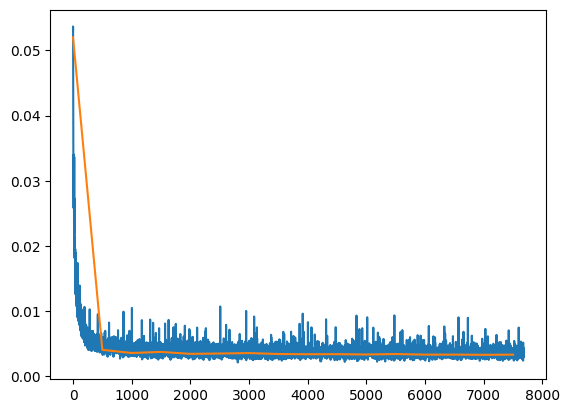

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_iter_i, train_loss)
plt.plot(val_iter_i, val_loss)

# Inference

In [17]:
# run model on test set and save results
ids = []
preds = []

model.eval()

for data in test_data_loader:
  curr_ids = data["id"].tolist()
  with torch.no_grad():
    logits = model(road_type=data["road_type"].to(device),
                  lighting=data["lighting"].to(device),
                  weather=data["weather"].to(device),
                  time_of_day=data["time_of_day"].to(device),
                  num_lanes=data["num_lanes"].to(device),
                  speed_limit=data["speed_limit"].to(device),
                  curvature=data["curvature"].to(device),
                  reported_accidents=data["num_reported_accidents"].to(device),
                  road_signs_present = data["road_signs_present"].to(device),
                  public_road=data["public_road"].to(device),
                  holiday = data["holiday"].to(device),
                  school_season = data["school_season"].to(device))

  curr_preds = logits.cpu().tolist()


  ids += curr_ids
  preds += curr_preds

In [18]:
submission_df = pd.DataFrame({'id': ids, 'accident_risk': [p[0] for p in preds]})
submission_df.to_csv("/content/drive/MyDrive/road-accident-prediction/submission.csv", index=False)

In [19]:
# save the model
save_path = "/content/drive/MyDrive/road-accident-prediction/accident_predictor_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/road-accident-prediction/accident_predictor_model.pth
